# 4. Spatio-temporal diversity of MICROVINIFICATION 

In [2]:
!mkdir /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/microvinification/OTU

In [3]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/microvinification/OTU'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/microvinification/OTU


In [4]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [5]:
from qiime2 import Visualization
import qiime2 as q2
from qiime2 import Visualization
from skbio.stats.distance import permanova
from qiime2 import Artifact
from qiime2 import Metadata
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from skbio import DistanceMatrix
from qiime2.plugins import diversity as q2d

%matplotlib inline

In [6]:
md = Metadata.load('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv')
taxonomy = q2.Artifact.load('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy.qza')
table = q2.Artifact.load('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results/MicrobiomeMetabolome/ITS/PostMLF_closedOTU_table.qza')

# Analyse all sample types and years seperately 

In [7]:
%%bash

# Define the list of sample types and years
sample_types=('Post-MLF' 'Post-AF' 'MV-must')
years=('Year2021' 'Year2022' 'Year2023')

# Path to the metadata file
metadata_file="/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv"

# Create a temporary file to store combinations that exist in the metadata
valid_combinations="valid_combinations.txt"

# Clear the file if it already exists
> $valid_combinations

# Check metadata for available combinations
for samples in "${sample_types[@]}"; do
  for year in "${years[@]}"; do
    # Check if the combination exists in the metadata
    match_count=$(awk -F'\t' -v sample_type="$samples" -v year_cat="$year" \
      '$0 ~ sample_type && $0 ~ year_cat {count++} END {print count}' "$metadata_file")
    
    # If the combination is found, log it
    if [[ $match_count -gt 0 ]]; then
      echo "$samples,$year" >> $valid_combinations
    fi
  done
done

# Read valid combinations and process only these
while IFS=, read -r samples year; do
  echo "Processing $samples in $year"
  
  # Create directory for the sample type and year and navigate into it
  dir_name="${samples}_${year}"
  mkdir -p "./$dir_name"
  pushd "./$dir_name" > /dev/null

  # Filter table and representative sequences
  qiime feature-table filter-samples \
    --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/mv_filtered_table.qza \
    --m-metadata-file "$metadata_file" \
    --p-where "[sample_type]='$samples' AND [Year_Cat]='$year'" \
    --o-filtered-table "mv_${samples}_${year}_filtered_table.qza"

  qiime feature-table filter-seqs \
    --i-data /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/Sven-denoising-test/ITS/revcomp-trimmed-denoised/with-adjusted-parameters/ITS-revcomp-trimmed-ER-0.05-denoised-trunc-190-PFA-4.0-maxee-4.0-rep-seqs.qza \
    --i-table "mv_${samples}_${year}_filtered_table.qza" \
    --o-filtered-data "mv_${samples}_${year}_filtered_rep_seqs.qza"

  # Core diversity metrics
  qiime diversity core-metrics \
    --i-table "mv_${samples}_${year}_filtered_table.qza" \
    --p-sampling-depth 4500 \
    --m-metadata-file "$metadata_file" \
    --p-n-jobs 10 \
    --p-ignore-missing-samples \
    --output-dir cm4500/

  # Kmer diversity metrics
  qiime kmerizer core-metrics \
    --i-sequences "mv_${samples}_${year}_filtered_rep_seqs.qza" \
    --i-table "mv_${samples}_${year}_filtered_table.qza" \
    --p-sampling-depth 4500 \
    --m-metadata-file "$metadata_file" \
    --p-n-jobs auto \
    --output-dir kmer_cm4500/

  # PERMANOVA
  formula='Plot_ID'
  beta_metrics=('bray_curtis' 'jaccard')

  for m in "${beta_metrics[@]}"; do
    qiime diversity adonis \
      --i-distance-matrix "cm4500/${m}_distance_matrix.qza" \
      --m-metadata-file "$metadata_file" \
      --p-formula "${formula}" \
      --p-n-jobs 5 \
      --o-visualization "cm4500/adonis_${m}.qzv"

    qiime diversity adonis \
      --i-distance-matrix "kmer_cm4500/${m}_distance_matrix.qza" \
      --m-metadata-file "$metadata_file" \
      --p-formula "${formula}" \
      --p-n-jobs 5 \
      --o-visualization "kmer_cm4500/adonis_${m}.qzv"
  done

  # Export all distance matrices for Mantel
  qiime tools export --input-path cm4500/bray_curtis_distance_matrix.qza --output-path cm4500/bray_curtis_distance_matrix
  qiime tools export --input-path cm4500/jaccard_distance_matrix.qza --output-path cm4500/jaccard_distance_matrix
  qiime tools export --input-path kmer_cm4500/bray_curtis_distance_matrix.qza --output-path kmer_cm4500/bray_curtis_distance_matrix
  qiime tools export --input-path kmer_cm4500/jaccard_distance_matrix.qza --output-path kmer_cm4500/jaccard_distance_matrix

  # Return to the parent directory
  popd > /dev/null
done < $valid_combinations

# Clean up temporary file
rm $valid_combinations


Processing Post-MLF in Year2021
Saved FeatureTable[Frequency] to: mv_Post-MLF_Year2021_filtered_table.qza
Saved FeatureData[Sequence] to: mv_Post-MLF_Year2021_filtered_rep_seqs.qza
Saved FeatureTable[Frequency] to: cm4500/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: cm4500/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: cm4500/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: cm4500/evenness_vector.qza
Saved DistanceMatrix to: cm4500/jaccard_distance_matrix.qza
Saved DistanceMatrix to: cm4500/bray_curtis_distance_matrix.qza
Saved PCoAResults to: cm4500/jaccard_pcoa_results.qza
Saved PCoAResults to: cm4500/bray_curtis_pcoa_results.qza
Saved Visualization to: cm4500/jaccard_emperor.qzv
Saved Visualization to: cm4500/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: kmer_cm4500/rarefied_table.qza
Saved FeatureTable[Frequency] to: kmer_cm4500/kmer_table.qza
Saved SampleData[AlphaDiversity] to: kmer_cm4500/observed_features_vector.qza
Saved SampleD

Exported kmer_cm4500/jaccard_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory kmer_cm4500/jaccard_distance_matrix
Processing Post-AF in Year2022


Plugin error from feature-table:

  The resulting table is empty. This can happen if you filter all samples or features out of the table. Please check your filtering parameters and try again.

Debug info has been saved to /scratch/lfloerl/tmpdata/qiime2-q2cli-err-4i95c05w.log
Usage: qiime feature-table filter-seqs [OPTIONS]

  Filter features from sequences based on a feature table or metadata. See the
  filtering tutorial on https://docs.qiime2.org for additional details. This
  method can filter based on ids in a table or a metadata file, but not both
  (i.e., the table and metadata options are mutually exclusive).

Inputs:
  --i-data ARTIFACT FeatureData[Sequence¹ | AlignedSequence²]
                         The sequences from which features should be
                         filtered.                                  [required]
  --i-table ARTIFACT FeatureTable[Frequency]
                         Table containing feature ids used for id-based
                         filtering.    

                          the cache you are using.
  --no-recycle            Do not recycle results from a previous failed
                          pipeline run or save the results from this run for
                          future recycling.
  --parallel              Execute your action in parallel. This flag will use
                          your default parallel config.
  --parallel-config FILE  Execute your action in parallel using a config at
                          the indicated path.
  --example-data PATH     Write example data and exit.
  --citations             Show citations and exit.
  --use-cache DIRECTORY   Specify the cache to be used for the intermediate
                          work of this action. If not provided, the default
                          cache under $TMP/qiime2/<uname> will be used.
                          IMPORTANT FOR HPC USERS: If you are on an HPC system
                          and are using parallel execution it is important to
             

  --example-data PATH     Write example data and exit.
  --citations             Show citations and exit.
  --use-cache DIRECTORY   Specify the cache to be used for the intermediate
                          work of this action. If not provided, the default
                          cache under $TMP/qiime2/<uname> will be used.
                          IMPORTANT FOR HPC USERS: If you are on an HPC system
                          and are using parallel execution it is important to
                          set this to a location that is globally accessible
                          to all nodes in the cluster.
  --help                  Show this message and exit.

                  There were some problems with the command:                  
 (1/2) Invalid value for '--i-sequences': mv_Post-
  AF_Year2022_filtered_rep_seqs.qza does not exist.
 (2/2) Invalid value for '--i-table': mv_Post-AF_Year2022_filtered_table.qza
  does not exist.
Usage: qiime diversity adonis [OPTIONS]

  Determ

  action differs from beta_group_significance in that it accepts R formulae to
  perform multi-way ADONIS tests; beta_group_signficance only performs one-way
  tests. For more details, consult the reference manual available on the CRAN
  vegan page: https://CRAN.R-project.org/package=vegan

Inputs:
  --i-distance-matrix ARTIFACT
    DistanceMatrix       Matrix of distances between pairs of samples.
                                                                    [required]
Parameters:
  --m-metadata-file METADATA...
    (multiple            Sample metadata containing formula terms.
     arguments will be   
     merged)                                                        [required]
  --p-formula TEXT       Model formula containing only independent terms
                         contained in the sample metadata. These can be
                         continuous variables or factors, and they can have
                         interactions as in a typical R formula. E.g., the
       

  'cm4500/jaccard_distance_matrix.qza' does not exist.
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'kmer_cm4500/bray_curtis_distance_matrix.qza' does not exist.
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally trans

Processing Post-AF in Year2023
Saved FeatureTable[Frequency] to: mv_Post-AF_Year2023_filtered_table.qza
Saved FeatureData[Sequence] to: mv_Post-AF_Year2023_filtered_rep_seqs.qza
Saved FeatureTable[Frequency] to: cm4500/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: cm4500/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: cm4500/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: cm4500/evenness_vector.qza
Saved DistanceMatrix to: cm4500/jaccard_distance_matrix.qza
Saved DistanceMatrix to: cm4500/bray_curtis_distance_matrix.qza
Saved PCoAResults to: cm4500/jaccard_pcoa_results.qza
Saved PCoAResults to: cm4500/bray_curtis_pcoa_results.qza
Saved Visualization to: cm4500/jaccard_emperor.qzv
Saved Visualization to: cm4500/bray_curtis_emperor.qzv
Saved FeatureTable[Frequency] to: kmer_cm4500/rarefied_table.qza
Saved FeatureTable[Frequency] to: kmer_cm4500/kmer_table.qza
Saved SampleData[AlphaDiversity] to: kmer_cm4500/observed_features_vector.qza
Saved SampleData

#  Mantel tests - Geographic 

In [10]:
%%bash
folders=("Post-AF_Year2021" "MV-must_Year2022" "Post-MLF_Year2022" "Post-MLF_Year2023" "MV-must_Year2023" "Post-AF_Year2023" "Post-MLF_Year2021")
geodesic_path='/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/geodesic_distance_ITS/distance-matrix.tsv'

for folder in "${folders[@]}"
do
    folder_path_1="$folder/cm4500"
    folder_path_2="$folder/kmer_cm4500"

    # Call the R script and pass folder paths and geodesic matrix
    Rscript /home/lfloerl/microterroir/Microbiome/Other_scripts/mantel_test.R "$folder_path_1" "$folder_path_2" "$geodesic_path"
done

                                                      Test Mantel_statistic_r
1      Post-AF_Year2021/cm4500-bray_curtis_distance_matrix         0.12400207
2          Post-AF_Year2021/cm4500-jaccard_distance_matrix        -0.04999199
3 Post-AF_Year2021/kmer_cm4500-bray_curtis_distance_matrix         0.11818388
4     Post-AF_Year2021/kmer_cm4500-jaccard_distance_matrix        -0.07758746
  Significance
1        0.130
2        0.664
3        0.142
4        0.789
                                                      Test Mantel_statistic_r
1      MV-must_Year2022/cm4500-bray_curtis_distance_matrix       -0.049934124
2          MV-must_Year2022/cm4500-jaccard_distance_matrix       -0.290984552
3 MV-must_Year2022/kmer_cm4500-bray_curtis_distance_matrix       -0.104611331
4     MV-must_Year2022/kmer_cm4500-jaccard_distance_matrix        0.002898551
  Significance
1        0.523
2        0.953
3        0.663
4        0.410
                                                       Test Mantel_sta

In [11]:
# List of folders to loop through
folders = ["Post-AF_Year2021", "MV-must_Year2022", "Post-MLF_Year2022", "Post-MLF_Year2023", 
           "MV-must_Year2023", "Post-AF_Year2023", "Post-MLF_Year2021"]

# Initialize an empty list to store the results
all_results = []

# Loop through each folder and process the results
for folder in folders:
    # Define folder paths for the two subdirectories
    folder_path_2 = os.path.join(folder, "kmer_cm4500")
    
    # Define the paths for the mantel_results.tsv files
    mantel_path_2 = os.path.join(folder_path_2, "mantel_results.tsv")
    
    # Check if the mantel results file exists for folder_path_2
    if os.path.exists(mantel_path_2):
        # Read the mantel results file for folder_path_2
        df_2 = pd.read_csv(mantel_path_2, sep="\t")
        # Add the main folder, subfolder, and distance matrix type columns
        df_2['Main_Folder'] = folder
        df_2['Subfolder'] = 'kmer_cm4500'
        df_2['Distance_Matrix'] = df_2.apply(
            lambda row: 'bray_curtis_distance_matrix' if 'bray_curtis' in row['Test'] else 'jaccard_distance_matrix',
            axis=1
        )
        all_results.append(df_2)

# Concatenate all the results into a single dataframe
final_results = pd.concat(all_results, ignore_index=True)

# Reorder columns for the final result
final_results = final_results[['Main_Folder', 'Subfolder', 'Distance_Matrix', 'Mantel_statistic_r', 'Significance']]

# Display the final results
final_results

,Main_Folder,Subfolder,Distance_Matrix,Mantel_statistic_r,Significance
0,Post-AF_Year2021,kmer_cm4500,bray_curtis_distance_matrix,0.124002,0.130
1,Post-AF_Year2021,kmer_cm4500,jaccard_distance_matrix,-0.049992,0.664
2,Post-AF_Year2021,kmer_cm4500,bray_curtis_distance_matrix,0.118184,0.142
3,Post-AF_Year2021,kmer_cm4500,jaccard_distance_matrix,-0.077587,0.789
4,MV-must_Year2022,kmer_cm4500,bray_curtis_distance_matrix,-0.049934,0.523
5,MV-must_Year2022,kmer_cm4500,jaccard_distance_matrix,-0.290985,0.953
6,MV-must_Year2022,kmer_cm4500,bray_curtis_distance_matrix,-0.104611,0.663
7,MV-must_Year2022,kmer_cm4500,jaccard_distance_matrix,0.002899,0.410
8,Post-MLF_Year2022,kmer_cm4500,bray_curtis_distance_matrix,0.093281,0.301
9,Post-MLF_Year2022,kmer_cm4500,jaccard_distance_matrix,0.150474,0.296


## Visualize

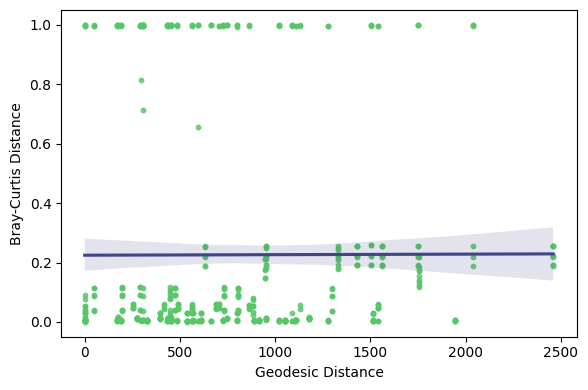

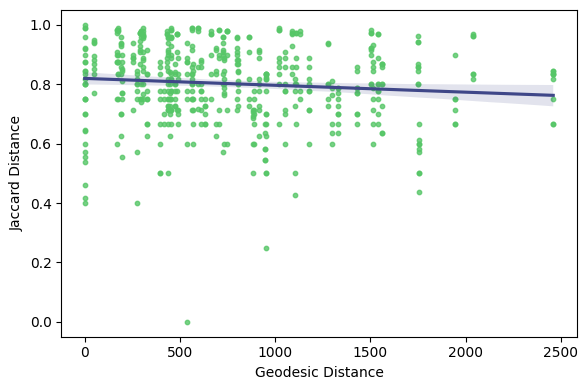

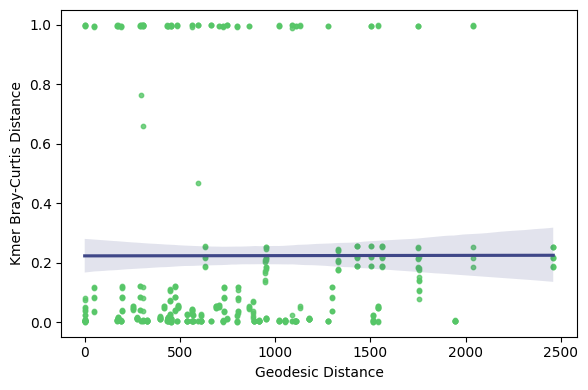

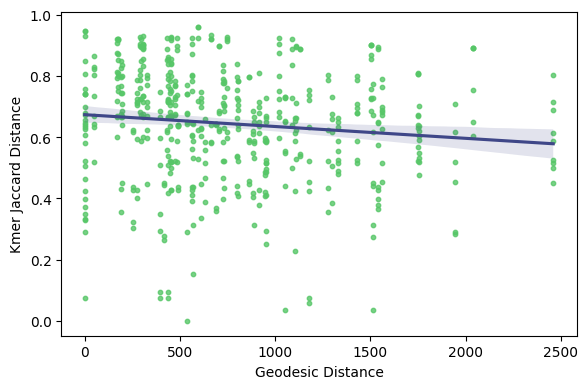

In [8]:
folder = 'Post-AF_Year2021'

dir_prefix = 'cm4500'
kmer_dir_prefix = 'kmer_cm4500'

geodesic_path = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/geodesic_distance_ITS/distance-matrix.tsv'

# Define paths for distance matrices
bray_curtis_path = os.path.join(folder, dir_prefix, 'bray_curtis_distance_matrix', 'distance-matrix.tsv')
jaccard_path = os.path.join(folder, dir_prefix, 'jaccard_distance_matrix', 'distance-matrix.tsv')
bray_curtis_kmer_path = os.path.join(folder, kmer_dir_prefix, 'bray_curtis_distance_matrix', 'distance-matrix.tsv')
jaccard_kmer_path = os.path.join(folder, kmer_dir_prefix, 'jaccard_distance_matrix', 'distance-matrix.tsv')

metrics = [bray_curtis_path, jaccard_path, bray_curtis_kmer_path, jaccard_kmer_path]

# Labels for the scatter plots
labels = [ ('Geodesic Distance', 'Bray-Curtis Distance'),
    ('Geodesic Distance', 'Jaccard Distance'),
    ('Geodesic Distance', 'Kmer Bray-Curtis Distance'),
    ('Geodesic Distance', 'Kmer Jaccard Distance')]

for metric, (x_label, y_label) in zip(metrics, labels):

    # Load the geodesic distance matrix
    dm1 = pd.read_csv(geodesic_path, sep='\t', index_col=0)

    # Load the other distance matrix
    dm2 = pd.read_csv(metric, sep='\t', index_col=0)

    # Align matrices by common indices
    common_ids = dm1.index.intersection(dm2.index)
    if len(common_ids) == 0:
        raise ValueError(f"No common IDs found between {geodesic_path} and {metric}.")

    dm1 = dm1.loc[common_ids, common_ids]
    dm2 = dm2.loc[common_ids, common_ids]

    # Extract upper triangular values (excluding diagonal)
    dm1_flat = dm1.where(np.triu(np.ones(dm1.shape), k=1).astype(bool)).stack()
    dm2_flat = dm2.where(np.triu(np.ones(dm2.shape), k=1).astype(bool)).stack()

    # Create scatter plot with regression line
    plt.figure(figsize=(6, 4))
    sns.regplot(x=dm1_flat, y=dm2_flat, scatter_kws={'s': 10, 'color': '#56C667FF'}, line_kws={'color': '#3F4788FF'})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()


#  Mantel tests - Plot Properties (delete) 

not sure how much sense this makes 

In [14]:
%%bash
folders=("Post-AF_Year2021" "MV-must_Year2022" "Post-AF_Year2022" "Post-MLF_Year2023" "MV-must_Year2023" "Post-AF_Year2023" "Post-MLF_Year2021")
geodesic_path='/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/plots_distance_matrix.tsv'

for folder in "${folders[@]}"
do
    folder_path_1="$folder/cm4500"
    folder_path_2="$folder/kmer_cm4500"

    # Call the R script and pass folder paths and geodesic matrix
    Rscript /home/lfloerl/microterroir/Microbiome/Other_scripts/mantel_test.R "$folder_path_1" "$folder_path_2" "$geodesic_path"
done

                                                      Test Mantel_statistic_r
1      Post-AF_Year2021/cm4500-bray_curtis_distance_matrix         0.21026581
2          Post-AF_Year2021/cm4500-jaccard_distance_matrix        -0.03338695
3 Post-AF_Year2021/kmer_cm4500-bray_curtis_distance_matrix         0.20415110
4     Post-AF_Year2021/kmer_cm4500-jaccard_distance_matrix        -0.04589211
  Significance
1        0.020
2        0.636
3        0.017
4        0.684
                                                      Test Mantel_statistic_r
1      MV-must_Year2022/cm4500-bray_curtis_distance_matrix        -0.10632411
2          MV-must_Year2022/cm4500-jaccard_distance_matrix        -0.27026849
3 MV-must_Year2022/kmer_cm4500-bray_curtis_distance_matrix         0.02279315
4     MV-must_Year2022/kmer_cm4500-jaccard_distance_matrix         0.06034256
  Significance
1        0.672
2        0.931
3        0.417
4        0.373
                                                      Test Mantel_stat

In [15]:

# List of folders to loop through
folders = ["Post-AF_Year2021", "MV-must_Year2022", "Post-AF_Year2022", "Post-MLF_Year2023", 
           "MV-must_Year2023", "Post-AF_Year2023", "Post-MLF_Year2021"]

# Initialize an empty list to store the results
all_results = []

# Loop through each folder and process the results
for folder in folders:
    # Define folder paths for the two subdirectories
    folder_path_2 = os.path.join(folder, "kmer_cm4500")
    
    # Define the paths for the mantel_results.tsv files
    mantel_path_2 = os.path.join(folder_path_2, "mantel_results.tsv")
    
    # Check if the mantel results file exists for folder_path_2
    if os.path.exists(mantel_path_2):
        # Read the mantel results file for folder_path_2
        df_2 = pd.read_csv(mantel_path_2, sep="\t")
        # Add the main folder, subfolder, and distance matrix type columns
        df_2['Main_Folder'] = folder
        df_2['Subfolder'] = 'kmer_cm4500'
        df_2['Distance_Matrix'] = df_2.apply(
            lambda row: 'bray_curtis_distance_matrix' if 'bray_curtis' in row['Test'] else 'jaccard_distance_matrix',
            axis=1
        )
        all_results.append(df_2)

# Concatenate all the results into a single dataframe
final_results = pd.concat(all_results, ignore_index=True)

# Reorder columns for the final result
final_results = final_results[['Main_Folder', 'Subfolder', 'Distance_Matrix', 'Mantel_statistic_r', 'Significance']]

# Display the final results
final_results

,Main_Folder,Subfolder,Distance_Matrix,Mantel_statistic_r,Significance
0,Post-AF_Year2021,cm4500,bray_curtis_distance_matrix,0.210266,0.020
1,Post-AF_Year2021,cm4500,jaccard_distance_matrix,-0.033387,0.636
2,Post-AF_Year2021,kmer_cm4500,bray_curtis_distance_matrix,0.210266,0.020
3,Post-AF_Year2021,kmer_cm4500,jaccard_distance_matrix,-0.033387,0.636
4,Post-AF_Year2021,kmer_cm4500,bray_curtis_distance_matrix,0.204151,0.017
5,Post-AF_Year2021,kmer_cm4500,jaccard_distance_matrix,-0.045892,0.684
6,MV-must_Year2022,cm4500,bray_curtis_distance_matrix,-0.106324,0.672
7,MV-must_Year2022,cm4500,jaccard_distance_matrix,-0.270268,0.931
8,MV-must_Year2022,kmer_cm4500,bray_curtis_distance_matrix,-0.106324,0.672
9,MV-must_Year2022,kmer_cm4500,jaccard_distance_matrix,-0.270268,0.931


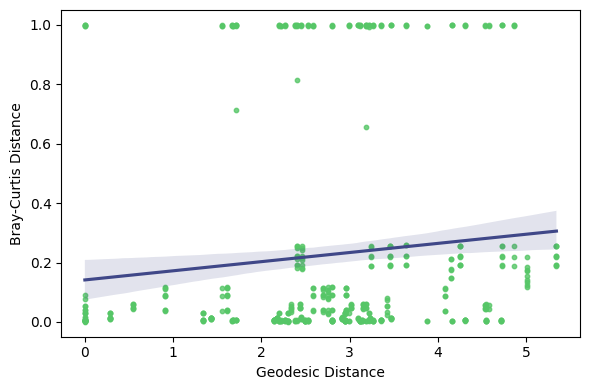

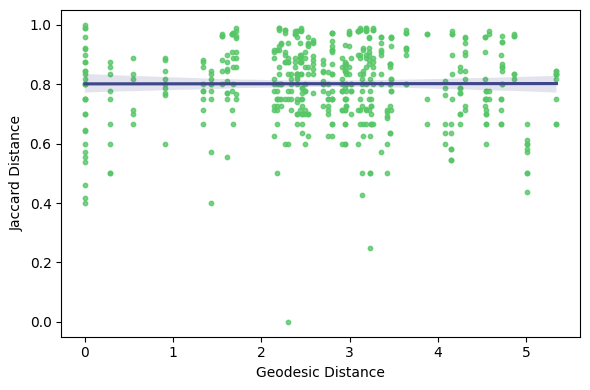

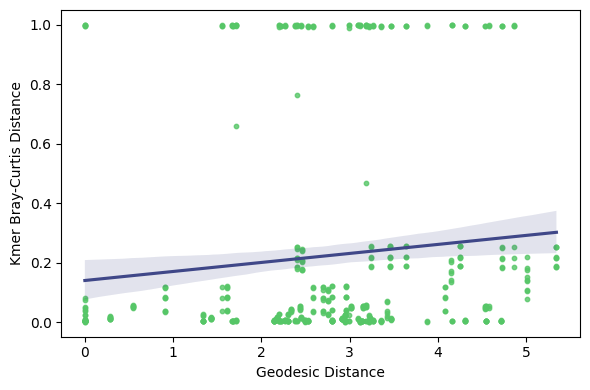

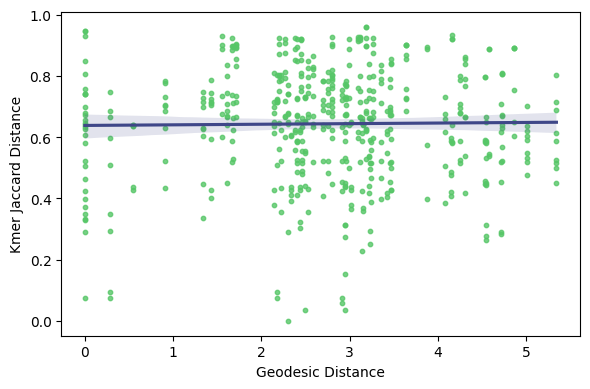

In [16]:
folder = 'Post-AF_Year2021'

dir_prefix = 'cm4500'
kmer_dir_prefix = 'kmer_cm4500'

geodesic_path='/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/plots_distance_matrix.tsv'

# Define paths for distance matrices
bray_curtis_path = os.path.join(folder, dir_prefix, 'bray_curtis_distance_matrix', 'distance-matrix.tsv')
jaccard_path = os.path.join(folder, dir_prefix, 'jaccard_distance_matrix', 'distance-matrix.tsv')
bray_curtis_kmer_path = os.path.join(folder, kmer_dir_prefix, 'bray_curtis_distance_matrix', 'distance-matrix.tsv')
jaccard_kmer_path = os.path.join(folder, kmer_dir_prefix, 'jaccard_distance_matrix', 'distance-matrix.tsv')

metrics = [bray_curtis_path, jaccard_path, bray_curtis_kmer_path, jaccard_kmer_path]

# Labels for the scatter plots
labels = [ ('Geodesic Distance', 'Bray-Curtis Distance'),
    ('Geodesic Distance', 'Jaccard Distance'),
    ('Geodesic Distance', 'Kmer Bray-Curtis Distance'),
    ('Geodesic Distance', 'Kmer Jaccard Distance')]

for metric, (x_label, y_label) in zip(metrics, labels):

    # Load the geodesic distance matrix
    dm1 = pd.read_csv(geodesic_path, sep='\t', index_col=0)

    # Load the other distance matrix
    dm2 = pd.read_csv(metric, sep='\t', index_col=0)

    # Align matrices by common indices
    common_ids = dm1.index.intersection(dm2.index)
    if len(common_ids) == 0:
        raise ValueError(f"No common IDs found between {geodesic_path} and {metric}.")

    dm1 = dm1.loc[common_ids, common_ids]
    dm2 = dm2.loc[common_ids, common_ids]

    # Extract upper triangular values (excluding diagonal)
    dm1_flat = dm1.where(np.triu(np.ones(dm1.shape), k=1).astype(bool)).stack()
    dm2_flat = dm2.where(np.triu(np.ones(dm2.shape), k=1).astype(bool)).stack()

    # Create scatter plot with regression line
    plt.figure(figsize=(6, 4))
    sns.regplot(x=dm1_flat, y=dm2_flat, scatter_kws={'s': 10, 'color': '#56C667FF'}, line_kws={'color': '#3F4788FF'})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()


# PERMANOVA 

* geographic: 'Quadrant' and 'Cluster'
* Plot properties: 'Plot_PCA_kMeans_Cluster'

In [145]:
md.to_dataframe()

,SAMPLE_NAME,Fungal conc. (ng/uL),Collection_ID,sample_type,Plot_ID,COLLECTION_DATE,Replicate,Time_point,Year,Year_Cat,...,Hydromorphie,Hydromorphie_code,Geology,Coordinates,Latitude,Longitude,Quadrant,Cluster,Plot_PCA_kMeans_Cluster,washed
id,,,,,,,,,,,,,,,,,,,,,
364526_290-LP3-ITS-0866,Lavaux_2021-08-31_bark_Plot4,2.7,Veraison_2021,bark,Lavaux_Plot_4,2021-08-31 00:00:00 +0200,NaN,Veraison,2021.0,Year2021,...,Slightly_redox,1.0,Molasse,46°29′55.815″N 6°42′29.007″E,46.498857,6.708072,NW,Cluster3,Cluster1,no
364526_289-LP3-ITS-0865,Lavaux_2021-08-31_bark_Plot5,1.6,Veraison_2021,bark,Lavaux_Plot_5,2021-08-31 00:00:00 +0200,NaN,Veraison,2021.0,Year2021,...,no_redox,0.0,Molasse,46°29′47.037″N 6°42′31.353″E,46.496407,6.708712,SW,Cluster3,Cluster3,no
364526_285-LP3-ITS-0861,Lavaux_2021-08-31_bark_Plot9,5.3,Veraison_2021,bark,Lavaux_Plot_9,2021-08-31 00:00:00 +0200,NaN,Veraison,2021.0,Year2021,...,no_redox,0.0,Molasse,46°29′57.936″N 6°42′44.103″E,46.499468,6.712242,NE,Cluster3,Cluster2,no
364526_287-LP3-ITS-0863,Lavaux_2021-08-31_bark_Plot11,1.4,Veraison_2021,bark,Lavaux_Plot_11,2021-08-31 00:00:00 +0200,NaN,Veraison,2021.0,Year2021,...,Slightly_redox,1.0,Gravel_moraine,46°30′00.818″N 6°42′23.968″E,46.500244,6.706655,NW,Cluster3,Cluster1,no
364526_282-LP3-ITS-0858,Lavaux_2021-08-31_bark_Plot12,2.2,Veraison_2021,bark,Lavaux_Plot_12,2021-08-31 00:00:00 +0200,NaN,Veraison,2021.0,Year2021,...,Slightly_redox,1.0,Colluvium,46°30′09.426″N 6°42′17.825″E,46.502628,6.704952,NW,Cluster1,Cluster1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364526_497-LP3-ITS-1073,Lavaux_2022-08-10_leaf_Plot11_washed,0.4,Veraison_2022,leaf,Lavaux_Plot_11,10.08.2022,NaN,Veraison,2022.0,Year2022,...,Slightly_redox,1.0,Gravel_moraine,46°30′00.818″N 6°42′23.968″E,46.500244,6.706655,NW,Cluster3,Cluster1,washed
364526_500-LP3-ITS-1076,Lavaux_2022-08-10_leaf_Plot13_washed,0.7,Veraison_2022,leaf,Lavaux_Plot_13,10.08.2022,NaN,Veraison,2022.0,Year2022,...,Slightly_redox,1.0,Molasse,46°29′59.656″N 6°42′21.944″E,46.499992,6.706109,NW,Cluster3,Cluster1,washed
364526_505-LP3-ITS-1081,Lavaux_2022-08-10_leaf_Plot9_washed,0.1,Veraison_2022,leaf,Lavaux_Plot_9,10.08.2022,NaN,Veraison,2022.0,Year2022,...,no_redox,0.0,Molasse,46°29′57.936″N 6°42′44.103″E,46.499468,6.712242,NE,Cluster3,Cluster2,washed


In [146]:
%%bash 


# Define the list of folders
folders=("Post-AF_Year2021" "MV-must_Year2022" "Post-AF_Year2022" "Post-MLF_Year2023" "MV-must_Year2023" "Post-AF_Year2023" "Post-MLF_Year2021")

# Path to the metadata file
metadata_file="/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv"

# Loop over the folders
for folder in "${folders[@]}"; do
  echo "Processing $folder"
  
  # Extract sample type and year from the folder name
  sample_type=$(echo "$folder" | cut -d'_' -f1)
  year=$(echo "$folder" | cut -d'_' -f2)
  
  # Create directory for the sample type and year and navigate into it
  dir_name="${sample_type}_${year}"
  pushd "$dir_name" > /dev/null
  
  # PERMANOVA
  formula='Plot_PCA_kMeans_Cluster'
  beta_metrics=('bray_curtis' 'jaccard')

  for m in "${beta_metrics[@]}"; do
    qiime diversity adonis \
      --i-distance-matrix "cm4500/${m}_distance_matrix.qza" \
      --m-metadata-file "$metadata_file" \
      --p-formula "${formula}" \
      --p-n-jobs 5 \
      --o-visualization "cm4500/adonis_${formula}_${m}.qzv"

    qiime diversity adonis \
      --i-distance-matrix "kmer_cm4500/${m}_distance_matrix.qza" \
      --m-metadata-file "$metadata_file" \
      --p-formula "${formula}" \
      --p-n-jobs 5 \
      --o-visualization "kmer_cm4500/adonis_${formula}_${m}.qzv"
  done

  # Return to the parent directory
  popd > /dev/null
done


Processing Post-AF_Year2021
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_jaccard.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_kMeans_Cluster_jaccard.qzv
Processing MV-must_Year2022
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_jaccard.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_kMeans_Cluster_jaccard.qzv
Processing Post-AF_Year2022
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_kMeans_Cluster_bray_curtis.qzv
Saved Visualization to: cm4500/adonis_Plot_PCA_kMeans_Cluster_jaccard.qzv
Saved Visualization to: kmer_cm4500/adonis_Plot_PCA_k

* Post-AF_Year2021" "Post-AF_Year2022" "Post-AF_Year2023" 
* "Post-MLF_Year2023" "Post-MLF_Year2021"
* "MV-must_Year2022" "MV-must_Year2023" 

In [182]:
# Define the folder and formula
folder = "Post-MLF_Year2021"
formula = "Plot_PCA_kMeans_Cluster"

In [183]:
Visualization.load(f"{folder}/cm4500/adonis_{formula}_bray_curtis.qzv")

<visualization: Visualization uuid: d58902fd-5360-41ab-ba89-2a2772b8945e>

In [184]:
Visualization.load(f"{folder}/cm4500/adonis_{formula}_jaccard.qzv")

<visualization: Visualization uuid: 552141c9-b090-4014-b447-83611627054e>

In [185]:
Visualization.load(f"{folder}/kmer_cm4500/adonis_{formula}_bray_curtis.qzv")

<visualization: Visualization uuid: ab664847-2f35-490c-8551-ef573de0cc74>

In [186]:
Visualization.load(f"{folder}/kmer_cm4500/adonis_{formula}_jaccard.qzv")

<visualization: Visualization uuid: 3592c12d-12f5-459d-9b9c-f634ee8345fe>

# Partial Mantel tests 

Run partial Mantel tests with plot properties and control for spatial distance

> **note. we calculate the Pearson (P) and Spearman (S) correlation for the simple Mantel tests**

--> nothing significant

In [78]:
%%bash 

# Define directory prefixes for the different matrices
dir_prefix='Post-MLF_Year2021'

# Define paths for distance matrices
bray_curtis_path="${dir_prefix}/cm4500/bray_curtis_distance_matrix/distance-matrix.tsv"
jaccard_path="${dir_prefix}/cm4500/jaccard_distance_matrix/distance-matrix.tsv"
bray_curtis_kmer_path="${dir_prefix}/kmer_cm4500/bray_curtis_distance_matrix/distance-matrix.tsv"
jaccard_kmer_path="${dir_prefix}/kmer_cm4500/jaccard_distance_matrix/distance-matrix.tsv"

# Define other distance matrices (spatial and plot properties)
spatial_matrix='/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/geodesic_distance_ITS/distance-matrix.tsv'
plot_properties_matrix='/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/plot_properties_euclidian_distance_matrix.tsv'

# List of matrices to process
matrices=("$bray_curtis_path" "$jaccard_path" "$bray_curtis_kmer_path" "$jaccard_kmer_path")

# Prepare an empty list to store results
result_list=()

# Iterate over the list of matrices
for matrix in "${matrices[@]}"
do
    # Run the R script for each matrix
    echo "$matrix"
    Rscript /home/lfloerl/microterroir/Microbiome/Other_scripts/partial_mantel.R "$matrix" "$spatial_matrix" "$plot_properties_matrix"
    echo "---------------------------------------------------------------------------"
done

Post-MLF_Year2021/cm4500/bray_curtis_distance_matrix/distance-matrix.tsv
                                    Test Mantel_statistic_r Significance
1               Microbial vs Spatial (P)        -0.30677093        0.985
2               Microbial vs Spatial (S)        -0.17776335        0.867
3              Microbial vs Matrix 2 (P)         0.08587479        0.329
4              Microbial vs Matrix 2 (S)        -0.03224468        0.500
5 Micro. vs Matrix 2 (ctrl. for Spatial)         0.14422447        0.219
6 Micro. vs Spatial (ctrl. for Matrix 2)        -0.32613105        0.994
---------------------------------------------------------------------------
Post-MLF_Year2021/cm4500/jaccard_distance_matrix/distance-matrix.tsv
                                    Test Mantel_statistic_r Significance
1               Microbial vs Spatial (P)        -0.03768983        0.575
2               Microbial vs Spatial (S)        -0.09889773        0.764
3              Microbial vs Matrix 2 (P)         0.0